load dataset

In [1]:
import os
import pandas as pd
import requests
import time
from datetime import datetime, timedelta
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import numpy as np

c:\Users\31615\anaconda3\envs\thesis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set the directory
os.chdir(r"C:\Users\...")

# Confirm the current directory
print("Current Directory:", os.getcwd())

Current Directory: C:\Users\31615\Desktop\thesis\triples


In [3]:
# Load entity and relation mappings as dictionaries
entity2text = pd.read_csv("data/wn18rr/entity2text.txt", sep="\t", header=None, names=["entity", "text"]).set_index("entity")["text"].to_dict()
relation2text = pd.read_csv("data/wn18rr/relation2text.txt", sep="\t", header=None, names=["relation", "text"]).set_index("relation")["text"].to_dict()

# Load the test.tsv file
test_data = pd.read_csv("data/wn18rr/test.tsv", sep="\t", header=None, names=["head", "relation", "tail"])

# Display the data (optional)
print("Entity to Text Mapping:", entity2text)
print("Relation to Text Mapping:", relation2text)
print("Test Data:")
print(test_data.head())

Entity to Text Mapping: {14854262: 'stool, solid excretory product evacuated from the bowels', 590383: 'chieftainship, the position of chieftain', 8769179: 'saxony, an area in Germany around the upper Elbe river; the original home of the Saxons', 2338145: 'ondatra zibethica, beaver-like aquatic rodent of North America with dark glossy brown fur', 1990168: 'founder, sink below the surface', 11812094: 'rose campion, an old cottage garden plant of southeastern Europe widely cultivated for its attractive white woolly foliage and showy crimson flowers', 7491708: 'enjoyment, the pleasure felt when having a good time', 2106662: 'german shepherd dog, breed of large shepherd dogs used in police work and as a guide for the blind', 1667449: 'quilt, stitch or sew together; "quilt the skirt"', 8838556: 'wake island, an island in the western Pacific between Guam and Hawaii', 1973759: 'raise, move upwards; "lift one\'s eyes"', 8349548: 'admiralty, the department in charge of the navy (as in Great Bri

In [ ]:
model = "llama-3.3-70b-versatile"
#llama-3.2-11b-vision-preview	
#llama-3.2-90b-vision-preview	
#deepseek-r1-distill-llama-70b	
#gpt-4


llama query 

In [4]:
# Replace with your Groq API URL and API key
GROQ_API_URL = "https://api.groq.com/openai/v1/chat/completions"
API_KEY = "..." 



# Rate limits
MAX_REQUESTS_PER_MINUTE = 30
MAX_REQUESTS_PER_DAY = 7000
MAX_TOKENS_PER_MINUTE = 7000
MAX_TOKENS_PER_DAY = 500000

# Tracking usage
requests_this_minute = 0
requests_today = 0
tokens_this_minute = 0
tokens_today = 0
minute_start_time = datetime.now()
day_start_time = datetime.now()


def reset_minute_tracker():
    """Reset the per-minute tracking variables."""
    global requests_this_minute, tokens_this_minute, minute_start_time
    requests_this_minute = 0
    tokens_this_minute = 0
    minute_start_time = datetime.now()


def reset_day_tracker():
    """Reset the per-day tracking variables."""
    global requests_today, tokens_today, day_start_time
    requests_today = 0
    tokens_today = 0
    day_start_time = datetime.now()



In [5]:
def rate_limited_query_lp(prompt):
    """
    Query the LLAMA model via an API, ensuring rate limits are adhered to.
    If rate limit (429) occurs, waits 60 seconds and retries the same query.
    Args:
        prompt (str): The prompt to query the model.
    Returns:
        str: Model's response ('Yes' or 'No').
    """
    global requests_this_minute, requests_today, tokens_this_minute, tokens_today

    while True:
        # Reset per-minute or per-day counters if needed
        now = datetime.now()
        if now - minute_start_time >= timedelta(minutes=1):
            reset_minute_tracker()
        if now - day_start_time >= timedelta(days=1):
            reset_day_tracker()

        # Prepare API request
        headers = {
            "Authorization": f"Bearer {API_KEY}",
            "Content-Type": "application/json",
        }

        data = {
            "model": model,
            "messages": [{"role": "user", "content": prompt}],
            "max_tokens": 150,  # Adjust based on actual expected token usage
            "temperature": 0.7,
        }

        try:
            response = requests.post(GROQ_API_URL, headers=headers, json=data)

            # Log response for debugging
            print("Status Code:", response.status_code)
            print("Response Content:", response.text)

            # Handle rate limit error (429)
            if response.status_code == 429:
                print("Rate limit hit. Waiting 60 seconds before retrying...")
                time.sleep(60)  # Wait for 60 seconds
                continue  # Retry the same request

            # Handle other non-200 status codes
            if response.status_code != 200:
                return f"API error: {response.status_code} - {response.text}"

            # Parse the response content
            result = response.json()
            message = result.get("choices", [{}])[0].get("message", {}).get("content", "").strip()

            # Update tracking metrics
            requests_this_minute += 1
            requests_today += 1
            tokens_used = len(data["messages"][0]["content"].split()) + data["max_tokens"]
            tokens_this_minute += tokens_used
            tokens_today += tokens_used

            # Ensure a valid response is returned
            if not message:
                return "No valid response received from the API."

            # Simplify response to 'Yes' or 'No'
            if "Yes" in message:
                return "Yes"
            elif "No" in message:
                return "No"
            else:
                return "No"  # Default fallback for ambiguous responses
        except requests.exceptions.RequestException as e:
            return f"An error occurred: {e}"


task 1: link prediction

In [6]:
def link_prediction_prompt(head, relation, tail, entity2text, relation2text):
    """
    Generate a meaningful prompt for link prediction by incorporating text descriptions.
    Args:
        head (str): Head entity ID.
        relation (str): Relation ID.
        tail (str): Tail entity ID.
        entity2text (dict): Mapping of entity IDs to descriptions.
        relation2text (dict): Mapping of relation IDs to descriptions.
    Returns:
        str: Formatted prompt for the LLM.
    """
    head_text = entity2text.get(head, head)  # Use description if available
    tail_text = entity2text.get(tail, tail)
    relation_text = relation2text.get(relation, relation)
    return f"Is the following triple valid? Head: {head_text}, Relation: {relation_text}, Tail: {tail_text}. Answer with 'Yes' or 'No'."

def perform_link_prediction(test_data, entity2text, relation2text, api_func):
    """
    Perform link prediction on all test data.
    Args:
        test_data (DataFrame): DataFrame with triples to test.
        entity2text (dict): Mapping of entity IDs to descriptions.
        relation2text (dict): Mapping of relation IDs to descriptions.
        api_func (function): Function to query the LLM.
    Returns:
        DataFrame: DataFrame containing triples, prompts, and predictions.
    """
    results = []
    for _, row in test_data.iterrows():
        # Generate a meaningful prompt
        prompt = link_prediction_prompt(row['head'], row['relation'], row['tail'], entity2text, relation2text)
        
        # Query the LLM
        response = api_func(prompt)
        
        # Save results
        results.append({
            'head': row['head'],
            'relation': row['relation'],
            'tail': row['tail'],
            'prompt': prompt,
            'prediction': response
        })
    
    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df


In [7]:
negative_samples = pd.read_csv("data/wn18rr/test_negative_samples.tsv", sep="\t", header=None, names=["head", "relation", "tail"])

link prediction on negative samples

In [8]:
# Perform link prediction
negative_lp_results = perform_link_prediction(negative_samples, entity2text, relation2text, rate_limited_query_lp)

# Save the results to a TSV file
output_file = "results/{model}/wn18rr/negative_lp.tsv"
negative_lp_results.to_csv(output_file, sep="\t", index=False)

print(f"Link prediction results saved to: {output_file}")

Status Code: 200
Response Content: {"id":"chatcmpl-f1bcc58b-920b-4709-821d-cfe9239f27d9","object":"chat.completion","created":1734976130,"model":"llama-3.3-70b-versatile","choices":[{"index":0,"message":{"role":"assistant","content":"No."},"logprobs":null,"finish_reason":"stop"}],"usage":{"queue_time":0.004606981999999999,"prompt_tokens":97,"prompt_time":0.013019947,"completion_tokens":3,"completion_time":0.012713709,"total_tokens":100,"total_time":0.025733656},"system_fingerprint":"fp_1ae2705acb","x_groq":{"id":"req_01jfta5kvcexg8sqy0x38z0pvh"}}

Status Code: 200
Response Content: {"id":"chatcmpl-0478f3d8-b400-47e5-8712-b85db20c960b","object":"chat.completion","created":1734976131,"model":"llama-3.3-70b-versatile","choices":[{"index":0,"message":{"role":"assistant","content":"No."},"logprobs":null,"finish_reason":"stop"}],"usage":{"queue_time":0.160610233,"prompt_tokens":107,"prompt_time":0.014542978,"completion_tokens":3,"completion_time":0.010909091,"total_tokens":110,"total_time":0

link prediction on positive samples 

In [9]:
# Perform link prediction
positive_lp_results = perform_link_prediction(test_data, entity2text, relation2text, rate_limited_query_lp)

# Save the results to a TSV file
output_file = "results/{model}/wn18rr/positive_lp.tsv"
positive_lp_results.to_csv(output_file, sep="\t", index=False)

print(f"Link prediction results saved to: {output_file}")

Status Code: 200
Response Content: {"id":"chatcmpl-07d93427-6c57-4eeb-8ef5-83bc511d0d7c","object":"chat.completion","created":1734976856,"model":"llama-3.3-70b-versatile","choices":[{"index":0,"message":{"role":"assistant","content":"Yes."},"logprobs":null,"finish_reason":"stop"}],"usage":{"queue_time":0.033332609,"prompt_tokens":97,"prompt_time":0.013529734,"completion_tokens":3,"completion_time":0.010909091,"total_tokens":100,"total_time":0.024438825},"system_fingerprint":"fp_1ae2705acb","x_groq":{"id":"req_01jftavrtwepvtdydb08j7rgv1"}}

Status Code: 200
Response Content: {"id":"chatcmpl-c805acb8-e96e-43f8-98ac-5bcdf066045a","object":"chat.completion","created":1734976857,"model":"llama-3.3-70b-versatile","choices":[{"index":0,"message":{"role":"assistant","content":"Yes."},"logprobs":null,"finish_reason":"stop"}],"usage":{"queue_time":0.005805526000000002,"prompt_tokens":140,"prompt_time":0.017951718,"completion_tokens":3,"completion_time":0.010909091,"total_tokens":143,"total_time"

evaluation of link prediction; 1st combine positve and negative sampling

In [7]:
def add_is_negative_and_binary(data, is_negative_value):
    """
    Add `is_negative` and `score` columns to a dataset.

    Args:
        data (DataFrame): Input dataset with columns ['head', 'relation', 'tail', 'prediction'].
        is_negative_value (int): 0 for positive samples, 1 for negative samples.

    Returns:
        DataFrame: Updated dataset with `is_negative` and `score` columns.
    """
    # Add `is_negative` column
    data['is_negative'] = is_negative_value

    # Compute `score`
    def compute_binary(prediction, is_negative):
        if is_negative == 0:  # Positive sample
            return 1 if prediction.lower() == 'yes' else 0
        else:  # Negative sample
            return 1 if prediction.lower() == 'no' else 0

    data['score'] = data.apply(
        lambda row: compute_binary(row['prediction'], row['is_negative']),
        axis=1
    )
    return data

In [9]:
positive_data = pd.read_csv('results\{model}\wn18rr\positive_lp.tsv', sep="\t", header=None, names=["head", "relation", "tail", "prompt", "prediction"])
negative_data = pd.read_csv(r'results\{model}\wn18rr\negative_lp.tsv', sep="\t", header=None, names=["head", "relation", "tail", "prompt", "prediction"])

positive_data = add_is_negative_and_binary(positive_data, is_negative_value=0)
negative_data = add_is_negative_and_binary(negative_data, is_negative_value=1)

# Merge the datasets
combined_data = pd.concat([positive_data, negative_data], ignore_index=True)

# Save or inspect the combined data
combined_data.to_csv('results/{model}/wn18rr/combined_lp_results.csv', index=False)

In [2]:
def evaluate_precision_recall_f1(predictions):
    """
    Evaluate link prediction results using Precision, Recall, and F1 score.
    
    Args:
        predictions (DataFrame): DataFrame with columns:
            - 'prediction': Model's prediction ("Yes" or "No")
            - 'is_negative': 0 for valid triples, 1 for invalid triples

    Returns:
        dict: Dictionary containing Precision, Recall, and F1 scores.
    """
    # Calculate True Positives (TP), False Positives (FP), False Negatives (FN)
    tp = len(predictions[(predictions['prediction'].str.lower() == 'yes') & (predictions['is_negative'] == 0)])
    fp = len(predictions[(predictions['prediction'].str.lower() == 'yes') & (predictions['is_negative'] == 1)])
    fn = len(predictions[(predictions['prediction'].str.lower() == 'no') & (predictions['is_negative'] == 0)])
    
    # Compute metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return {
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }


In [10]:
# Load predictions from the combined link prediction results
predictions = pd.read_csv('results/{model}/wn18rr/combined_lp_results.csv')

# Evaluate Precision, Recall, and F1
evaluation_metrics = evaluate_precision_recall_f1(predictions)

# Display the metrics
print("Precision:", evaluation_metrics["Precision"])
print("Recall:", evaluation_metrics["Recall"])
print("F1 Score:", evaluation_metrics["F1 Score"])

Precision: 0.978021978021978
Recall: 0.8944723618090452
F1 Score: 0.9343832020997376


task 2: relation prediction

In [10]:
def rate_limited_query_rp(prompt):
    """
    Query the LLM model via an API, ensuring rate limits are adhered to.
    Args:
        prompt (str): The prompt to query the model.
    Returns:
        str: Model's response (relation text from the list of possible relations).
    """
    global requests_this_minute, requests_today, tokens_this_minute, tokens_today

    while True:
        # Reset per-minute or per-day counters if needed
        now = datetime.now()
        if now - minute_start_time >= timedelta(minutes=1):
            reset_minute_tracker()
        if now - day_start_time >= timedelta(days=1):
            reset_day_tracker()

        # Prepare API request
        headers = {
            "Authorization": f"Bearer {API_KEY}",
            "Content-Type": "application/json",
        }

        data = {
            "model": "llama-3.3-70b-versatile",
            "messages": [{"role": "user", "content": prompt}],
            "max_tokens": 150,  # Adjust based on actual expected token usage
            "temperature": 0.7,
        }

        try:
            response = requests.post(GROQ_API_URL, headers=headers, json=data)

            # Log response for debugging
            print("Status Code:", response.status_code)
            print("Response Content:", response.text)

            # Handle rate limit error (429)
            if response.status_code == 429:
                print("Rate limit hit. Waiting 60 seconds before retrying...")
                time.sleep(60)  # Wait for 60 seconds
                continue  # Retry the same request

            # Handle other non-200 status codes
            if response.status_code != 200:
                return f"API error: {response.status_code} - {response.text}"

            # Parse the response content
            result = response.json()
            message = result.get("choices", [{}])[0].get("message", {}).get("content", "").strip()

            # Update tracking metrics
            requests_this_minute += 1
            requests_today += 1
            tokens_used = len(data["messages"][0]["content"].split()) + data["max_tokens"]
            tokens_this_minute += tokens_used
            tokens_today += tokens_used

            # Ensure a valid response is returned
            if not message:
                return "No valid response received from the API."

            # Return the model's response directly for relation prediction
            return message
        except requests.exceptions.RequestException as e:
            return f"An error occurred: {e}"

In [11]:
def relation_prediction_prompt(head, tail, entity2text, relation2text):
    """
    Generate a meaningful prompt for relation prediction by showing possible relations.
    Args:
        head (str): Head entity ID.
        tail (str): Tail entity ID.
        entity2text (dict): Mapping of entity IDs to descriptions.
        relation2text (dict): Mapping of relation IDs to descriptions.
    Returns:
        str: Formatted prompt for the LLM.
    """
    head_text = entity2text.get(head, head)  # Use description if available
    tail_text = entity2text.get(tail, tail)  # Use description if available
    possible_relations = ", ".join(relation2text.values())  # List of possible relations

    return (
        f"What is the most possible relation between the following entities (head and tail)?Choose one of the possible relations provided after entities. \n"
        f" Head: {head_text}\n"
        f" Tail: {tail_text}\n"
        f" Choose one of the possible relations: {possible_relations}."
        f" Provide an answer that which has the words for relation, no additional words"
    )


def integrate_relation_prediction(test_data, entity2text, relation2text, api_func):
    """
    Perform relation prediction and save evaluation results into a DataFrame.
    Args:
        test_data (DataFrame): DataFrame containing triples to test.
        entity2text (dict): Mapping of entity IDs to descriptions.
        relation2text (dict): Mapping of relation IDs to descriptions.
        api_func (function): Function to query the LLM.
    Returns:
        tuple: (evaluation_metrics_df, predictions_df)
            - evaluation_metrics_df: DataFrame with evaluation metrics.
            - predictions_df: DataFrame with prompts, predictions, and expected relations.
    """
    results = []
    for _, row in test_data.iterrows():
        # Create prompt
        prompt = relation_prediction_prompt(row['head'], row['tail'], entity2text,relation2text )
        response = api_func(prompt)  # Query the LLM for the relation
        
        # Map expected and predicted relations to descriptive text
        expected_relation = relation2text.get(row['relation'].lower(), row['relation'])
        predicted_relation = relation2text.get(response.lower(), response)

        results.append({
            'head': row['head'],
            'tail': row['tail'],
            'expected_relation': expected_relation,
            'predicted_relation': predicted_relation
            #'prompt': prompt
        })

    # Convert results to a DataFrame
    predictions_df = pd.DataFrame(results)

    return predictions_df

In [12]:
# Generate predictions
predictions_df = integrate_relation_prediction(test_data, entity2text, relation2text, rate_limited_query_rp)

# Save predictions to a CSV file
predictions_df.to_csv("results/{model}/wn18rr/rp_results.csv", index=False)

Status Code: 200
Response Content: {"id":"chatcmpl-ebc0a4be-5e1b-4bc3-954d-35413444b091","object":"chat.completion","created":1734982621,"model":"llama-3.3-70b-versatile","choices":[{"index":0,"message":{"role":"assistant","content":"instance hypernym"},"logprobs":null,"finish_reason":"stop"}],"usage":{"queue_time":0.00056989,"prompt_tokens":166,"prompt_time":0.019934323,"completion_tokens":4,"completion_time":0.014545455,"total_tokens":170,"total_time":0.034479778},"system_fingerprint":"fp_1ae2705acb","x_groq":{"id":"req_01jftgbp8kfkxaf780ckwh8jh5"}}

Status Code: 200
Response Content: {"id":"chatcmpl-9de850e1-b4bd-45e5-b227-8a1da39e0197","object":"chat.completion","created":1734982621,"model":"llama-3.3-70b-versatile","choices":[{"index":0,"message":{"role":"assistant","content":"derivationally related form"},"logprobs":null,"finish_reason":"stop"}],"usage":{"queue_time":0.0006283150000000008,"prompt_tokens":211,"prompt_time":0.024380702,"completion_tokens":5,"completion_time":0.0181

rp evaluation

In [7]:
# Load relation-to-text mappings
relation2text = pd.read_csv("data/wn18rr/relation2text.txt", sep="\t", header=None, names=["relation", "text"])
relation_texts = relation2text['text'].str.strip().str.lower().tolist()

# Load the predictions dataset
predictions = globals()[f"rp_{model}"]

# Normalize and map relations to their descriptive text
predictions['expected_relation'] = predictions['expected_relation'].str.strip().str.lower()
predictions['predicted_relation'] = predictions['predicted_relation'].str.strip().str.lower()

# Filter dataset to include only known relations
filtered_predictions = predictions[
    predictions['expected_relation'].isin(relation_texts) & 
    predictions['predicted_relation'].isin(relation_texts)
]

# Compute confusion matrix using relation texts
cm = confusion_matrix(
    filtered_predictions['expected_relation'],
    filtered_predictions['predicted_relation'],
    labels=relation_texts
)

# Convert confusion matrix to DataFrame
cm_df = pd.DataFrame(cm, index=relation_texts, columns=relation_texts)

# Generate a classification report
report = classification_report(
    filtered_predictions['expected_relation'],
    filtered_predictions['predicted_relation'],
    labels=relation_texts,
    output_dict=True
)
report_df = pd.DataFrame(report).transpose()


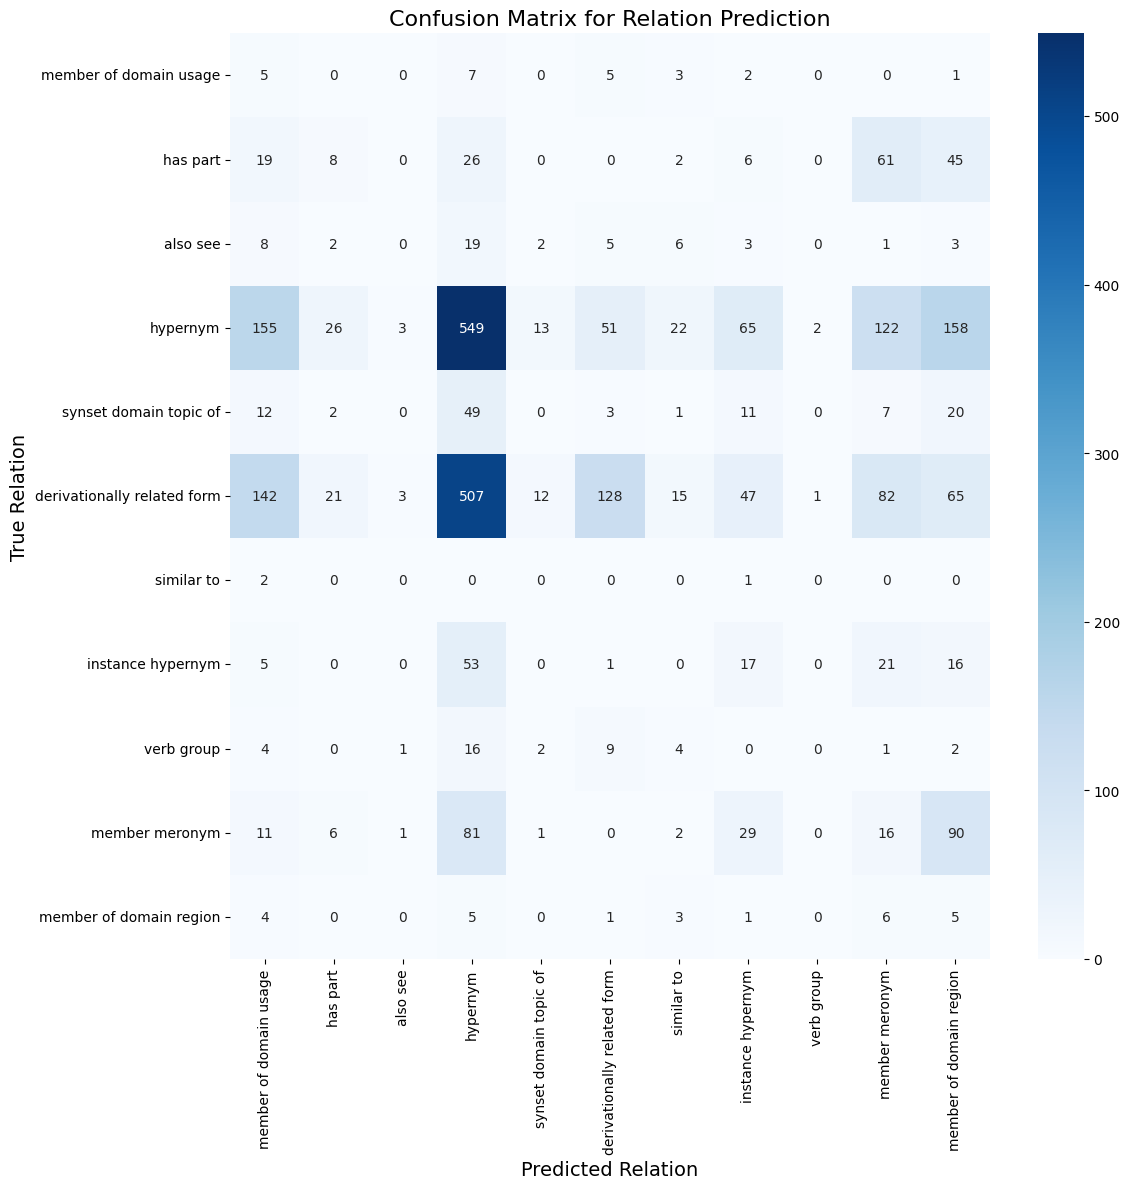

In [8]:
# Create the heatmap
plt.figure(figsize=(12,12 ))  # Adjust figure size as needed
sns.heatmap(
    cm_df, 
    annot=True,           # Show values in cells
    fmt="d",              # Format as integers
    cmap="Blues",         # Use a blue color palette
    xticklabels=cm_df.columns, 
    yticklabels=cm_df.index
)

# Add axis labels and title
plt.xlabel("Predicted Relation", fontsize=14)
plt.ylabel("True Relation", fontsize=14)
plt.title("Confusion Matrix for Relation Prediction", fontsize=16)

# Show the plot
plt.tight_layout()  # Adjust spacing to fit labels
plt.show()


In [9]:
# Step 1: Load relations dynamically from the relation2text file
relation2text = pd.read_csv("data/wn18rr/relation2text.txt", sep="\t", header=None, names=["relation", "text"])
relation_texts = relation2text['text'].str.strip().str.lower().tolist()

# Step 2: Load the model and encode relation texts
modelT = SentenceTransformer('all-MiniLM-L6-v2')
relation_embeddings = {
    text: modelT.encode(text, convert_to_tensor=True) for text in relation_texts
}

# Step 3: Load predictions dataset
predictions['expected_relation'] = predictions['expected_relation'].str.strip().str.lower()
predictions['predicted_relation'] = predictions['predicted_relation'].str.strip().str.lower()

# Step 4: Compute cosine similarity for each prediction
def compute_cosine_similarity(row):
    expected_embedding = relation_embeddings.get(row['expected_relation'], None)
    predicted_embedding = relation_embeddings.get(row['predicted_relation'], None)

    if expected_embedding is not None and predicted_embedding is not None:
        return util.pytorch_cos_sim(expected_embedding, predicted_embedding).item()
    return 0.0  # Default similarity if embeddings are missing

predictions['cosine_similarity'] = predictions.apply(compute_cosine_similarity, axis=1)

# Step 5: Remove duplicates and save results
predictions = predictions[['expected_relation', 'predicted_relation', 'cosine_similarity']].drop_duplicates()

# Save processed predictions
#predictions.to_csv(f"results/wn18rr/rp/{model}/rp_cosine_{model}.csv", index=False)

# Step 6: Compute pairwise similarity for all relations (11x11)
pairwise_similarities = []
seen_pairs = set()

for i, rel1 in enumerate(relation_texts):
    for j, rel2 in enumerate(relation_texts):
        pair = tuple(sorted([rel1, rel2]))
        if pair in seen_pairs:
            continue
        seen_pairs.add(pair)

        # Calculate similarity (including self-comparisons)
        similarity = util.pytorch_cos_sim(
            relation_embeddings[rel1],
            relation_embeddings[rel2]
        ).item()

        pairwise_similarities.append({
            "Relation 1": rel1,
            "Relation 2": rel2,
            "Cosine Similarity": similarity
        })


# Step 7: Save pairwise similarity results
pairwise_similarity_df = pd.DataFrame(pairwise_similarities)


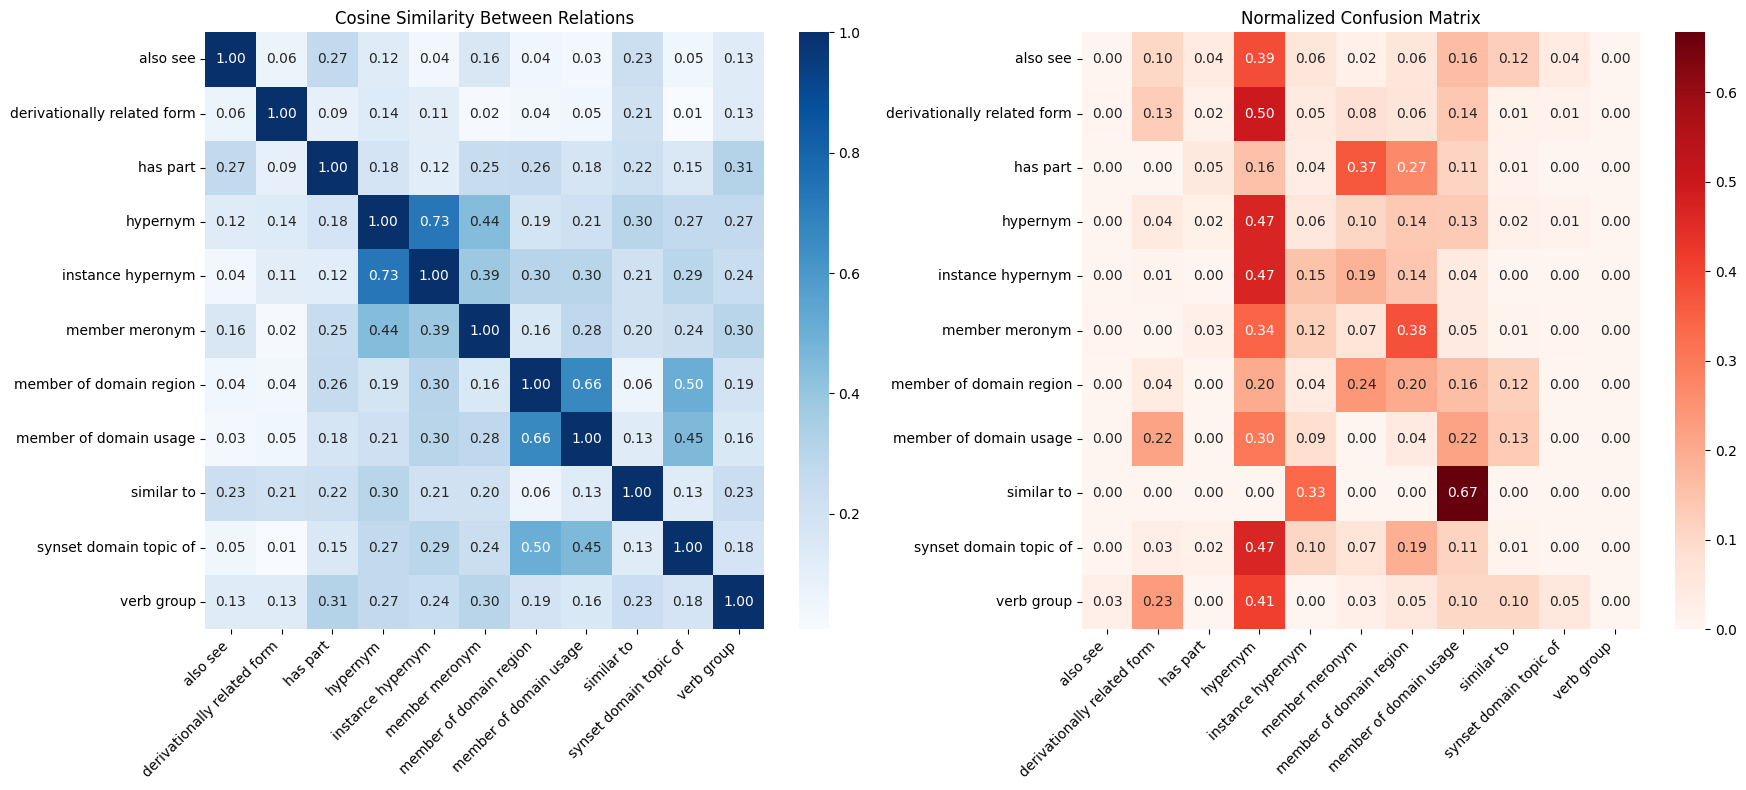

In [10]:
# Load pairwise similarity data

pairwise_similarity = pairwise_similarity_df

# Normalize relation names
pairwise_similarity['Relation 1'] = pairwise_similarity['Relation 1'].str.strip().str.lower()
pairwise_similarity['Relation 2'] = pairwise_similarity['Relation 2'].str.strip().str.lower()

# Combine unique relation names
relation_texts = sorted(set(pairwise_similarity['Relation 1']).union(set(pairwise_similarity['Relation 2'])))

# Create a mapping for relation indices
relation_to_index = {relation: idx for idx, relation in enumerate(relation_texts)}

# Build the similarity matrix
similarity_matrix = np.zeros((len(relation_texts), len(relation_texts)))
for _, row in pairwise_similarity.iterrows():
    idx1 = relation_to_index.get(row['Relation 1'])
    idx2 = relation_to_index.get(row['Relation 2'])
    if idx1 is not None and idx2 is not None:
        similarity_matrix[idx1, idx2] = row['Cosine Similarity']
        similarity_matrix[idx2, idx1] = row['Cosine Similarity']  # Symmetric matrix

# Load and normalize confusion matrix
#confusion_matrix_df = pd.read_csv(f"results/wn18rr/rp/{model}/weighted_confusion_matrix_{model}.csv", index_col=0)
confusion_matrix_df = cm_df
confusion_matrix_df.index = confusion_matrix_df.index.str.strip().str.lower()
confusion_matrix_df.columns = confusion_matrix_df.columns.str.strip().str.lower()

# Reorder confusion matrix to match the relation order
confusion_matrix_df = confusion_matrix_df.loc[relation_texts, relation_texts]

# Normalize confusion matrix by row totals
confusion_matrix = confusion_matrix_df.values
normalized_confusion_matrix = np.nan_to_num(
    confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)
)

# Create heatmaps
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Cosine Similarity Heatmap
sns.heatmap(
    similarity_matrix,
    annot=True,
    fmt=".2f",
    xticklabels=relation_texts,
    yticklabels=relation_texts,
    ax=axes[0],
    cmap="Blues",
)
axes[0].set_title("Cosine Similarity Between Relations")
axes[0].set_xticklabels(relation_texts, rotation=45, ha="right")
axes[0].set_yticklabels(relation_texts, rotation=0)

# Confusion Matrix Heatmap
sns.heatmap(
    normalized_confusion_matrix,
    annot=True,
    fmt=".2f",
    xticklabels=relation_texts,
    yticklabels=relation_texts,
    ax=axes[1],
    cmap="Reds",
)
axes[1].set_title("Normalized Confusion Matrix")
axes[1].set_xticklabels(relation_texts, rotation=45, ha="right")
axes[1].set_yticklabels(relation_texts, rotation=0)

plt.tight_layout()
plt.show()

# Save the updated heatmap
fig.savefig(f"results/{model}/wn18rr/aligned_relation_similarity_vs_confusion_matrix.png", dpi=300)
plt.close()  # Close the figure to avoid conflicts with subsequent figures


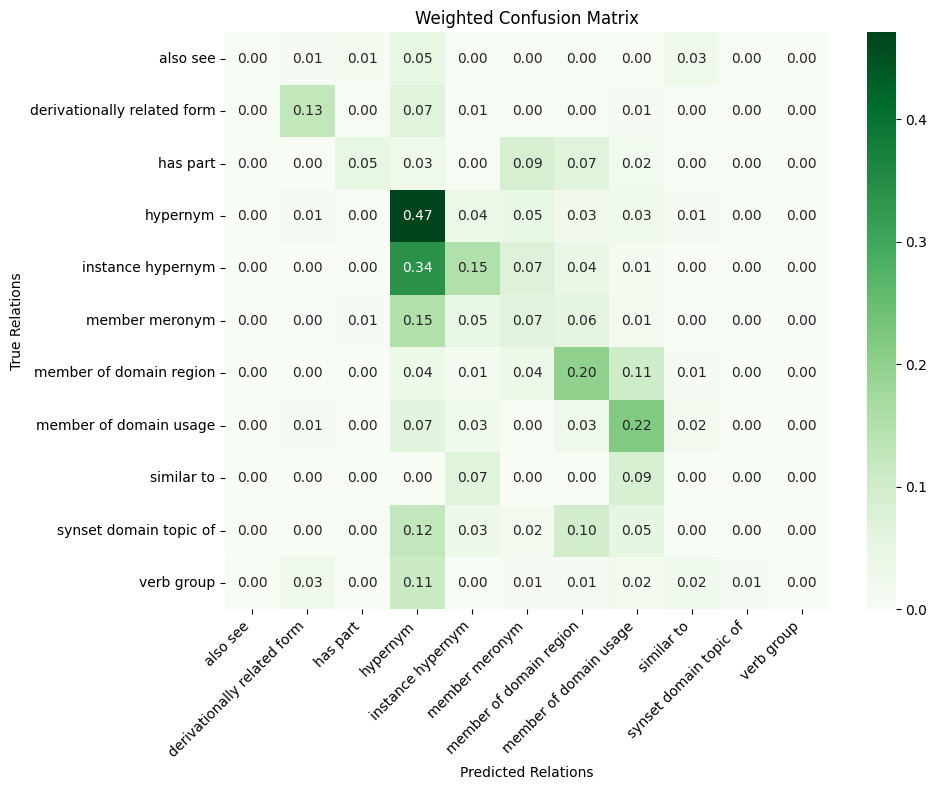

In [11]:
# Load pairwise similarity data

# Normalize relation names
pairwise_similarity['Relation 1'] = pairwise_similarity['Relation 1'].str.strip().str.lower()
pairwise_similarity['Relation 2'] = pairwise_similarity['Relation 2'].str.strip().str.lower()

# Combine unique relation names
relation_texts = sorted(set(pairwise_similarity['Relation 1']).union(set(pairwise_similarity['Relation 2'])))

# Create a mapping for relation indices
relation_to_index = {relation: idx for idx, relation in enumerate(relation_texts)}

# Build the similarity matrix
similarity_matrix = np.zeros((len(relation_texts), len(relation_texts)))
for _, row in pairwise_similarity.iterrows():
    idx1 = relation_to_index.get(row['Relation 1'])
    idx2 = relation_to_index.get(row['Relation 2'])
    if idx1 is not None and idx2 is not None:
        similarity_matrix[idx1, idx2] = row['Cosine Similarity']
        similarity_matrix[idx2, idx1] = row['Cosine Similarity']  # Symmetric matrix

# Load and normalize confusion matrix
#confusion_matrix_df = pd.read_csv(f"llama/results/wn18rr/rp/{model}/weighted_confusion_matrix_{model}.csv", index_col=0)
confusion_matrix_df.index = confusion_matrix_df.index.str.strip().str.lower()
confusion_matrix_df.columns = confusion_matrix_df.columns.str.strip().str.lower()

# Reorder confusion matrix to match the relation order
confusion_matrix_df = confusion_matrix_df.loc[relation_texts, relation_texts]

# Normalize confusion matrix by row totals
confusion_matrix = confusion_matrix_df.values
normalized_confusion_matrix = np.nan_to_num(
    confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)
)

# Compute the weighted confusion matrix
weighted_confusion_matrix = normalized_confusion_matrix * similarity_matrix

# Save the weighted confusion matrix
weighted_cm_df = pd.DataFrame(weighted_confusion_matrix, index=relation_texts, columns=relation_texts)
#weighted_cm_df.to_csv(f"llama/results/wn18rr/rp/{model}/weighted_confusion_matrix_{model}_weighted.csv", index=True)

# Plot the weighted confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    weighted_confusion_matrix,
    annot=True,
    fmt=".2f",
    xticklabels=relation_texts,
    yticklabels=relation_texts,
    cmap="Greens"
)
plt.title("Weighted Confusion Matrix")
plt.xlabel("Predicted Relations")
plt.ylabel("True Relations")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f"results/{model}/wn18rr/weighted_cm.png", dpi=300)
plt.show()
plt.close()  # Close the figure after saving


In [12]:
# Compute metrics based on the weighted confusion matrix
true_positives = np.diag(weighted_confusion_matrix)  # Diagonal values represent true positives
false_positives = weighted_confusion_matrix.sum(axis=0) - true_positives  # Column-wise sum minus true positives
false_negatives = weighted_confusion_matrix.sum(axis=1) - true_positives  # Row-wise sum minus true positives
true_negatives = weighted_confusion_matrix.sum() - (true_positives + false_positives + false_negatives)

# Accuracy
accuracy = true_positives.sum() / weighted_confusion_matrix.sum()

# Precision
precision = np.divide(
    true_positives,
    true_positives + false_positives,
    out=np.zeros_like(true_positives, dtype=float),
    where=(true_positives + false_positives) != 0
)

# Recall
recall = np.divide(
    true_positives,
    true_positives + false_negatives,
    out=np.zeros_like(true_positives, dtype=float),
    where=(true_positives + false_negatives) != 0
)

# F1 Score
f1_score = np.divide(
    2 * precision * recall,
    precision + recall,
    out=np.zeros_like(precision, dtype=float),
    where=(precision + recall) != 0
)

# Create a DataFrame to display metrics
metrics_df = pd.DataFrame({
    "Relation": relation_texts,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1_score
})

# Print metrics
print("Overall Accuracy:", accuracy)
print("Per-Relation Metrics:")
print(metrics_df)

# Save metrics to CSV
metrics_df.to_csv(f"results/{model}/wn18rr/metrics.csv", index=False)


Overall Accuracy: 0.351253045587589
Per-Relation Metrics:
                       Relation  Precision    Recall  F1 Score
0                      also see   0.000000  0.000000  0.000000
1   derivationally related form   0.694911  0.580608  0.632638
2                      has part   0.646234  0.182878  0.285081
3                      hypernym   0.325369  0.745628  0.453044
4             instance hypernym   0.386194  0.241906  0.297477
5                member meronym   0.197673  0.193580  0.195605
6       member of domain region   0.372846  0.497887  0.426388
7        member of domain usage   0.386614  0.596914  0.469281
8                    similar to   0.000000  0.000000  0.000000
9        synset domain topic of   0.000000  0.000000  0.000000
10                   verb group   0.000000  0.000000  0.000000
